# Simulate preparing a GHZ state and compute covariance

In this notebook, we simulate preparation of the $n$-qubit GHZ state
$$
\vert\text{GHZ}\rangle = \frac1{\sqrt2} \Bigl( \vert0\dots0\rangle + \vert1\dots1\rangle \Bigr)
$$
via the unitary circuit
$$
\vert\text{GHZ}\rangle = \text{CNOT}_{n-1,n} \dots \text{CNOT}_{1,2} H_1 \vert 0 \dots 0 \rangle
$$
where the Hadamard and CNOT gates are given by
\begin{align}
H &= \frac1{\sqrt2} \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}, 
&
\text{CNOT} &= \vert0\rangle\langle0\vert \otimes \mathbb 1 + \vert1\rangle\langle1\vert \otimes \sigma_X, &
&
\sigma_X = \begin{pmatrix}0 & 1\\1 & 0\end{pmatrix}.
\end{align}


Applicable keywords:

- Efficient classical simulation of a unitary circuit

- Quantum computation

- Quantum information

- Matrix product states, tensor trains

- Matrix product operators (MPO), matrix product density operators (MPDO)

- Tensor network methods

The code below uses Python and `mpnum` (http://mpnum.readthedocs.io/). This notebook is part of https://github.com/milan-hl/mpnum-examples/. 

## Definitions

Open ``init.ipynb`` to see which MPSs and MPOs it defines.

In [1]:
%run init.ipynb

In [2]:
# Let's do 6 qubits
n_sites = 6

The Hadamard and CNOT gates are constructed as follows:
\begin{align}
  H &= \frac1{\sqrt 2}(\sigma_X + \sigma_Z) \\
  \text{CNOT} &= \vert0\rangle\langle0\vert \otimes \mathbb 1 + \vert1\rangle\langle1\vert \otimes \sigma_X
\end{align}
where $\sigma_{X,Y,Z}$ are Pauli matrices.

With `mpnum` and the definitions from `init.ipynb`, we have e.g.
\begin{align}
  \vert1\rangle\langle1\vert \otimes \sigma_X &= \texttt{mp.chain((mdd, mpx))}
\end{align}

In [3]:
# Define Hadamard gate (single qubit)
mh = (mpx + mpz) / 2**0.5

# Define CNOT gate (two qubits)
mcnot = mp.chain((muu, mid)) + mp.chain((mdd, mpx))

Here, we compute
$$
\Vert H H^\dagger - \mathbb 1 \Vert_F
$$
where the Norm is the Frobenius norm $\Vert A \Vert_F^2 = \operatorname{tr}(A^\dagger A)$ and $A^\dagger$ denotes the Hermitian adjoint (cojugate transpose). 

In [4]:
# Verify that Hadamard is unitary
mp.normdist(mp.dot(mh, mh.adj()), mp.factory.eye(1, ldim))

3.1401849173675503e-16

In [5]:
# Verify that CNOT is unitary
mp.normdist(mp.dot(mcnot, mcnot.adj()), mp.factory.eye(2, ldim))

0.0

## Prepare GHZ as MPS

Define a pure state, containing spin up on `n_sites` sites:

In [6]:
psi = mp.chain([mup] * n_sites)

Number of sites of the pure state:

In [7]:
len(psi)

6

Number of sites on which the two gates act:

In [8]:
len(mh), len(mcnot)

(1, 2)

In [9]:
psi = mp.chain([mup] * n_sites)
# Apply Hadamard at site 0 (the first site)
psi = mp.partialdot(mh, psi, 0)

print(psi.ranks)

for pos in range(n_sites - 1):
    # Apply CNOT at sites (pos, pos + 1)
    psi = mp.partialdot(mcnot, psi, pos)
    print(psi.ranks)

(1, 1, 1, 1, 1)
(2, 1, 1, 1, 1)
(2, 2, 1, 1, 1)
(2, 2, 2, 1, 1)
(2, 2, 2, 2, 1)
(2, 2, 2, 2, 2)


The output shows that each application of a CNOT gate increases the bond dimension (=rank) by a factor of two (=the bond dimension/rank of the CNOT gate).

The following function computes
$$
\text{cov}_\rho(A_i, B_j) = \text{tr}(A_i B_j \rho) - \text{tr}(A_i \rho) \text{tr}(B_j \rho)
$$
for a pure state $\rho = \vert\psi\rangle\langle\psi\vert$.

In [10]:
def cov_ab(psi, a, b, pos1, pos2):
    if pos1 == pos2:
        return np.nan  # Return not a number
    # Todo: Verify that imaginary parts are small
    # Apply a on site pos1
    ept_a = mp.inner(psi, mp.partialdot(a, psi, pos1)).real
    # Apply b on site pos2
    ept_b = mp.inner(psi, mp.partialdot(b, psi, pos2)).real
    ept_ab = mp.inner(
        psi,
        mp.partialdot(a, mp.partialdot(b, psi, pos2), pos1)
    ).real
    cov = ept_ab - ept_a * ept_b
    return cov

In [11]:
covariances = [
    [
        cov_ab(psi, mpz, mpz, pos1, pos2)
        for pos2 in range(n_sites)
    ]
    for pos1 in range(n_sites)
]

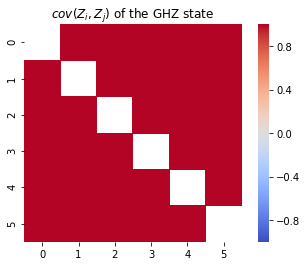

In [12]:
sns.heatmap(covariances, vmin=-1, vmax=1, cmap='coolwarm', square=True) \
    .set(title='$cov(Z_i, Z_j)$ of the GHZ state')
None

## Prepare GHZ as MPO

In [13]:
psi = mp.chain([mup] * n_sites)
rho = mp.mps_to_mpo(psi)
# Apply Hadamard at site 0 (the first site)
rho = mp.partialdot(mh, rho, 0)
rho = mp.partialdot(rho, mh.adj(), 0)

for pos in range(n_sites - 1):
    # Apply CNOT at sites (pos, pos + 1)
    rho = mp.partialdot(mcnot, rho, pos)
    rho = mp.partialdot(rho, mcnot.adj(), pos)

In [14]:
#rho.to_array_global().reshape([ldim**n_sites] * 2)

The following function computes the same covariance as `cov_ab()`, but for a mixed state provided as MPO.

In [15]:
def cov_ab_mpo(rho, a, b, pos1, pos2):
    # Todo: Verify that imaginary parts are small
    if pos1 == pos2:
        return np.nan
    ept_a = mp.trace(mp.partialdot(rho, a, pos1)).real
    ept_b = mp.trace(mp.partialdot(rho, b, pos2)).real
    ept_ab = mp.trace(mp.partialdot(a, mp.partialdot(b, rho, pos2), pos1)).real
    cov = ept_ab - ept_a * ept_b
    return cov

In [16]:
covariances_mpo = [
    [
        cov_ab_mpo(rho, mpz, mpz, pos1, pos2)
        for pos2 in range(n_sites)
    ]
    for pos1 in range(n_sites)
]

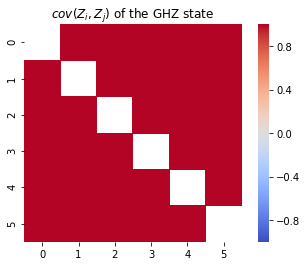

In [17]:
sns.heatmap(covariances_mpo, vmin=-1, vmax=1, cmap='coolwarm', square=True) \
    .set(title='$cov(Z_i, Z_j)$ of the GHZ state')
None

## Prepare GHZ as MPO, with errors

In [18]:
n_sites = 20

In [19]:
# Prepare GHZ as MPO with some error probability eta

eta = 0.1

psi = mp.chain([mup] * n_sites)
rho = mp.mps_to_mpo(psi)
# Apply Hadamard at site 0 (the first site)
rho = mp.partialdot(mh, rho, 0)
rho = mp.partialdot(rho, mh.adj(), 0)

for pos in range(n_sites - 1):
    rho_last = rho
    # Apply CNOT at sites (pos, pos + 1)
    rho = mp.partialdot(mcnot, rho, pos)
    rho = mp.partialdot(rho, mcnot.adj(), pos)
    # Apply CNOT with probability (1 - eta) only.
    rho = eta * rho_last + (1 - eta) * rho
    rho.compress(method='svd', relerr=1e-10)
    #print(rho.ranks)

In [20]:
covariances_mpo_eta = [
    [
        cov_ab_mpo(rho, mpz, mpz, pos1, pos2)
        for pos2 in range(n_sites)
    ]
    for pos1 in range(n_sites)
]

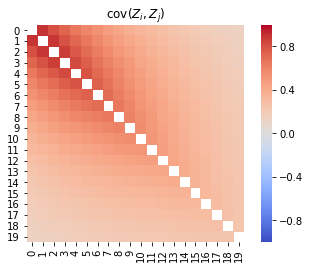

In [21]:
sns.heatmap(covariances_mpo_eta, vmin=-1, vmax=1, cmap='coolwarm', square=True) \
    .set(title='$\mathrm{cov}(Z_i, Z_j)$')
None